# Pandas

* memory usage of Parquet read in Pandas as Arrow or NumPy arrays
  * 2021+ 11GB 6s as Arrow
  * 2021+ 39GB 16s at NumPy

In [1]:
import pandas as pd
import polars as pl
from humanfriendly import format_size, format_number
from simpler_mpl import set_commas, set_common_mpl_styles
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

display(f"Pandas {pd.__version__}, Polars {pl.__version__}")

from cell_profiler import cell_profiler as cp

%start_cell_profiler


def show_rows_memory(df, deep=False):
    """
    Show rows and memory cost of a Pandas/Polars dataframe
    `deep=True` only has an impact on Pandas numpy-backed string columns, which otherwise are undercounted
    """
    num_bytes = 0
    df_type = "Unknown"
    try:
        num_bytes = df.estimated_size()  # try Polars
        df_type = "Polars"
    except AttributeError:
        pass
    try:
        num_bytes = df.memory_usage(deep=deep, index=False).sum()  # try Pandas
        df_type = "Pandas"
    except AttributeError:
        pass
    display(
        f"{df_type} df with {format_number(df.shape[0])} rows, {format_size(num_bytes)} bytes"
    )

'Pandas 2.0.1, Polars 0.17.10'

In [1] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 208.4 MiB


In [2]:
%stop_cell_profiler

'Profiling disabled'

In [3]:
dfpda = pd.read_parquet("../test_result_2021on.parquet", 
                        dtype_backend="pyarrow")

In [4]:
show_rows_memory(dfpda)

'Pandas df with 82,012,245 rows, 11.19 GB bytes'

In [5]:
dfpda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82012245 entries, 0 to 82012244
Data columns (total 14 columns):
 #   Column             Dtype                 
---  ------             -----                 
 0   test_id            int64[pyarrow]        
 1   vehicle_id         int64[pyarrow]        
 2   test_date          timestamp[ns][pyarrow]
 3   test_class_id      int64[pyarrow]        
 4   test_type          large_string[pyarrow] 
 5   test_result        large_string[pyarrow] 
 6   test_mileage       int64[pyarrow]        
 7   postcode_area      large_string[pyarrow] 
 8   make               large_string[pyarrow] 
 9   model              large_string[pyarrow] 
 10  colour             large_string[pyarrow] 
 11  fuel_type          large_string[pyarrow] 
 12  cylinder_capacity  int64[pyarrow]        
 13  first_use_date     timestamp[ns][pyarrow]
dtypes: int64[pyarrow](5), large_string[pyarrow](7), timestamp[ns][pyarrow](2)
memory usage: 10.4 GB


In [6]:
dfpdn = pd.read_parquet("../test_result_2021on.parquet", 
                        dtype_backend="numpy_nullable")

In [7]:
show_rows_memory(dfpdn, deep=True)

'Pandas df with 82,012,245 rows, 39.66 GB bytes'

In [8]:
dfpdn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82012245 entries, 0 to 82012244
Data columns (total 14 columns):
 #   Column             Dtype         
---  ------             -----         
 0   test_id            Int64         
 1   vehicle_id         Int64         
 2   test_date          datetime64[ns]
 3   test_class_id      Int64         
 4   test_type          object        
 5   test_result        object        
 6   test_mileage       Int64         
 7   postcode_area      object        
 8   make               object        
 9   model              object        
 10  colour             object        
 11  fuel_type          object        
 12  cylinder_capacity  Int64         
 13  first_use_date     datetime64[ns]
dtypes: Int64(5), datetime64[ns](2), object(7)
memory usage: 8.9+ GB


In [58]:
# /tmp/ipykernel_585982/2566587885.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
#dfpda.query('(test_mileage==171443) & (model=="V50") & (test_result=="P") & ', engine="python")
cols = ['test_date', 'test_class_id', 'test_type', 'test_result', 'test_mileage', 'make', 'model', 'colour', 'fuel_type', 'cylinder_capacity', 'first_use_date']
#dfpda.query('(test_id=="642012593")')[cols] # Ian's volvo v50
dfpda.query('(test_mileage==171443) & (model=="V50") & (colour=="BLUE")', engine='python')[cols] # Ian's volvo v50

,test_date,test_class_id,test_type,test_result,test_mileage,make,model,colour,fuel_type,cylinder_capacity,first_use_date
14856429,2022-05-12 00:00:00,4,NT,F,171443,VOLVO,V50,BLUE,DI,1997,2005-03-10 00:00:00
14908799,2022-05-12 00:00:00,4,RT,P,171443,VOLVO,V50,BLUE,DI,1997,2005-03-10 00:00:00


In [58] used -346.1 MiB RAM in 10.99s (system mean cpu 18%, single max cpu 100%), peaked 1489.9 MiB above final usage, current RAM usage now 18604.0 MiB


# Speed test

In [9]:
%timeit dfpda['make'].str.len()
# e.g. TOYOTA, VOLKSWAGEN

1.09 s ± 130 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit dfpdn['make'].str.len()

7.65 s ± 246 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit dfpda['test_class_id'].max()

83.1 ms ± 1.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%timeit dfpdn['test_class_id'].max()

167 ms ± 1.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [63]:
import numpy as np

np.testing.assert_approx_equal(74115.13, dfpda["test_mileage"].mean())
np.testing.assert_approx_equal(74115.13, dfpdn["test_mileage"].mean())

In [63] used 0.0 MiB RAM in 0.38s (system mean cpu 17%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 14750.4 MiB


In [14]:
%timeit dfpda['test_mileage'].mean()

60 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
%timeit dfpdn['test_mileage'].mean()

140 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
# IAN IS IT SANE TO TEST THE TIME OF 2 OPS - I REALLY NEED TO SEPARATE THESE...
# %timeit dfpda['test_mileage'].dropna().mean()

In [17]:
# %timeit dfpdn['test_mileage'].dropna().mean()

# Mileage vs first use year

### Subsample using NumPy and Arrow

**TODO**

In [18]:
%start_cell_profiler

'Profiling enabled'

In [18] used 24421.9 MiB RAM in 170.39s (system mean cpu 17%, single max cpu 100%), peaked 12239.8 MiB above final usage, current RAM usage now 24630.4 MiB


In [19]:
# df_fuel = dfpda[:10000].query('test_result=="P"')
# df_fuel = dfpda.query('test_result=="P"').sample(10_000)

In [19] used 0.0 MiB RAM in 0.10s (system mean cpu 5%, single max cpu 33%), peaked 0.0 MiB above final usage, current RAM usage now 24630.4 MiB


## How to get the rows and columns needed?

* query on test result is very slow
* mask on the same logical query is faster
* making the mask is very fast
* selecting rows then selecting columns is slow
* selecting subset of columns then applying mask is very fast

In [20]:
%time dfpda.query('test_result=="P"');

CPU times: user 7.24 s, sys: 4.32 s, total: 11.6 s
Wall time: 11.4 s
In [20] used 626.3 MiB RAM in 11.72s (system mean cpu 9%, single max cpu 100%), peaked 9139.4 MiB above final usage, current RAM usage now 25256.7 MiB


In [21]:
%%time
# similar results CoW enabled and disabled
with pd.option_context("mode.copy_on_write", True):
    dfpda.query('test_result=="P"');

CPU times: user 6.71 s, sys: 4.57 s, total: 11.3 s
Wall time: 11.2 s
In [21] used 0.0 MiB RAM in 11.31s (system mean cpu 8%, single max cpu 100%), peaked 9609.7 MiB above final usage, current RAM usage now 25256.7 MiB


In [22]:
# sanity check they're installed - they are
import bottleneck
import numexpr

In [22] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 25256.7 MiB


In [23]:
%time dfpda.query('test_result=="P"');

CPU times: user 6.63 s, sys: 4.31 s, total: 10.9 s
Wall time: 10.9 s
In [23] used 0.0 MiB RAM in 11.13s (system mean cpu 8%, single max cpu 100%), peaked 9534.4 MiB above final usage, current RAM usage now 25256.7 MiB


In [46]:
%time dfpda.eval('test_result=="P"'); 
# make mask with eval

CPU times: user 997 ms, sys: 171 ms, total: 1.17 s
Wall time: 1.04 s
In [46] used 0.0 MiB RAM in 1.14s (system mean cpu 9%, single max cpu 100%), peaked 779.9 MiB above final usage, current RAM usage now 25358.1 MiB


In [47]:
%%time 
pass_mask = dfpda["test_result"] == "P"; 
# make mask only

CPU times: user 391 ms, sys: 4.77 ms, total: 396 ms
Wall time: 394 ms
In [47] used 0.0 MiB RAM in 0.49s (system mean cpu 7%, single max cpu 100%), peaked 19.3 MiB above final usage, current RAM usage now 25358.1 MiB


In [25]:
%time dfpda[pass_mask]; 
# select all columns against mask

CPU times: user 5.97 s, sys: 4.11 s, total: 10.1 s
Wall time: 10 s
In [25] used 0.4 MiB RAM in 10.29s (system mean cpu 7%, single max cpu 100%), peaked 9175.8 MiB above final usage, current RAM usage now 25276.5 MiB


In [26]:
%%time
cols = ["test_mileage", "fuel_type", 
        "first_use_date"] 
dfpda[pass_mask][cols]; 
# select all columns after mask

CPU times: user 5.88 s, sys: 4.29 s, total: 10.2 s
Wall time: 10.1 s
In [26] used 0.0 MiB RAM in 10.27s (system mean cpu 8%, single max cpu 100%), peaked 9178.8 MiB above final usage, current RAM usage now 25276.5 MiB


In [65]:
%time dfpda[cols][pass_mask]; 
# select all columns before mask

CPU times: user 10.5 s, sys: 8.29 s, total: 18.8 s
Wall time: 19 s
In [65] used -163.7 MiB RAM in 19.95s (system mean cpu 11%, single max cpu 100%), peaked 7630.1 MiB above final usage, current RAM usage now 14614.3 MiB


In [27]:
%time dfpda[cols][pass_mask]; 
# select all columns before mask

CPU times: user 1.48 s, sys: 870 ms, total: 2.34 s
Wall time: 2.34 s
In [27] used 0.0 MiB RAM in 2.48s (system mean cpu 8%, single max cpu 100%), peaked 2498.2 MiB above final usage, current RAM usage now 25276.5 MiB


In [27]:
%time dfpda[cols][pass_mask]; 
# select all columns before mask

CPU times: user 1.48 s, sys: 870 ms, total: 2.34 s
Wall time: 2.34 s
In [27] used 0.0 MiB RAM in 2.48s (system mean cpu 8%, single max cpu 100%), peaked 2498.2 MiB above final usage, current RAM usage now 25276.5 MiB


In [28]:
%time
dfpda[dfpda["test_result"] == "P"];

CPU times: user 6.36 s, sys: 4.07 s, total: 10.4 s
Wall time: 10.4 s
In [28] used 0.1 MiB RAM in 10.64s (system mean cpu 8%, single max cpu 100%), peaked 9154.1 MiB above final usage, current RAM usage now 25276.6 MiB


In [29]:
%%time
df_fuel = dfpda.query('test_result=="P"').sample(10_000)

CPU times: user 8.89 s, sys: 4.41 s, total: 13.3 s
Wall time: 13.1 s
In [29] used 1.6 MiB RAM in 13.16s (system mean cpu 8%, single max cpu 100%), peaked 9211.4 MiB above final usage, current RAM usage now 25278.1 MiB


## The actual "work" is fast for pandas and polars

In [30]:
%%time
df_fuel = (
    df_fuel.assign(first_use_year=lambda dfx: dfx["first_use_date"].dt.year)[
        ["test_mileage", "fuel_type", "first_use_year"]
    ]
    .dropna()
    .query("fuel_type in ['PE', 'DI']")
)

CPU times: user 4.72 ms, sys: 203 µs, total: 4.92 ms
Wall time: 4.24 ms
In [30] used 0.6 MiB RAM in 0.11s (system mean cpu 4%, single max cpu 25%), peaked 0.0 MiB above final usage, current RAM usage now 25278.7 MiB


In [67]:
%%time
df_fuel = (
    dfpda.query('test_result=="P"')
    .sample(10_000)
    .assign(first_use_year=lambda dfx: dfx["first_use_date"].dt.year)[
        ["test_mileage", "fuel_type", "first_use_year"]
    ]
    .dropna()
    .query("fuel_type in ['PE', 'DI']")
)

CPU times: user 8.94 s, sys: 5.11 s, total: 14 s
Wall time: 13.9 s
In [67] used 0.8 MiB RAM in 13.99s (system mean cpu 10%, single max cpu 100%), peaked 9218.1 MiB above final usage, current RAM usage now 14618.9 MiB


In [32]:
# def add_year(dfx):
#    dfx['first_use_year'] = dfx['first_use_date'].dt.year
#    return dfx
# df_fuel = df_fuel.pipe(add_year)[['test_mileage', 'fuel_type', 'first_use_year']]. \

In [32] used 0.0 MiB RAM in 0.10s (system mean cpu 5%, single max cpu 18%), peaked 0.0 MiB above final usage, current RAM usage now 25278.4 MiB


In [33]:
# dfs_allfuel = dfpda.query('test_result=="P"').sample(10_000)
# dfs_allfuel['first_use_year'] = dfs_allfuel['first_use_date'].dt.year
# dfs_allfuel = dfs_allfuel[['test_mileage', 'fuel_type', 'first_use_year']]
# dfs_allfuel = dfs_allfuel.dropna() # some of the test_mileage rows are empty
# df_fuel = dfs_allfuel[dfs_allfuel['fuel_type'].isin(['PE', 'DI'])]

In [33] used 0.0 MiB RAM in 0.10s (system mean cpu 5%, single max cpu 25%), peaked 0.0 MiB above final usage, current RAM usage now 25278.4 MiB


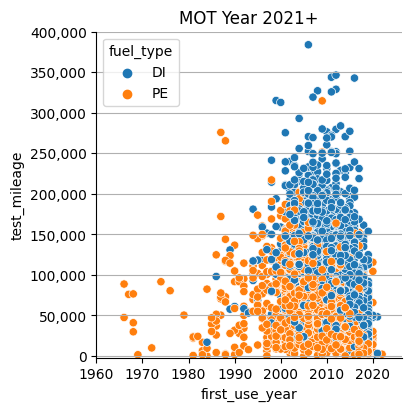

In [34] used 1.1 MiB RAM in 0.52s (system mean cpu 11%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 25279.6 MiB


In [34]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 4))
# Note this is Pandas Arrow with Seaborn
# TODO maybe different symbols
# h/t https://stackoverflow.com/questions/56394204/pandas-groupby-scatter-plot-in-a-single-plot for categorical solution
# sns.scatterplot(x=dfs['first_use_year'], y=dfs['test_mileage'], c=pd.Categorical(dfs['fuel_type']).codes, ax=ax)
sns.scatterplot(
    x=df_fuel["first_use_year"],
    y=df_fuel["test_mileage"],
    hue=df_fuel["fuel_type"],
    hue_order=["DI", "PE"],
    ax=ax,
)
# ax.scatter(x=dfs['first_use_year'], y=dfs['test_mileage'], c=pd.Categorical(dfs['fuel_type']).codes,)
ax.set_xlim(xmin=1960)
ax.set_ylim(ymax=400000)
set_commas(ax, y_axis=True)
set_common_mpl_styles(ax, ymin=-2000, title="MOT Year 2021+")

In [35]:
# dfs.info()

In [35] used 0.3 MiB RAM in 0.10s (system mean cpu 3%, single max cpu 18%), peaked 0.0 MiB above final usage, current RAM usage now 25279.9 MiB


# Old experiments to load in single file dumps

In [36]:
# dfpda2018 = pd.read_parquet('../test_result_2018on.parquet', dtype_backend="pyarrow")

In [36] used 0.0 MiB RAM in 0.10s (system mean cpu 8%, single max cpu 33%), peaked 0.0 MiB above final usage, current RAM usage now 25279.9 MiB


In [37]:
# dfpda2018.memory_usage(deep=True, index=False) # deep=True gives same answer as deep=False on Arrow

In [37] used 0.0 MiB RAM in 0.10s (system mean cpu 9%, single max cpu 50%), peaked 0.0 MiB above final usage, current RAM usage now 25279.9 MiB


In [38]:
# show_rows_memory(dfpda2018) # 198M rows, 27GB

In [38] used 0.0 MiB RAM in 0.10s (system mean cpu 12%, single max cpu 50%), peaked 0.0 MiB above final usage, current RAM usage now 25279.9 MiB


In [39]:
# dfpda2021 = pd.read_parquet('../test_result_2021on.parquet', dtype_backend="pyarrow")

In [39] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 25279.9 MiB


In [40]:
# show_rows_memory(dfpda2021) # 82M rows 11GB

In [40] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 25279.9 MiB


In [41]:
# dfpdn2021 = pd.read_parquet('../test_result_2021on.parquet', dtype_backend="numpy_nullable")

In [41] used 0.0 MiB RAM in 0.10s (system mean cpu 5%, single max cpu 23%), peaked 0.0 MiB above final usage, current RAM usage now 25279.9 MiB


In [42]:
# show_rows_memory(dfpdn2021)

In [42] used 0.0 MiB RAM in 0.10s (system mean cpu 5%, single max cpu 23%), peaked 0.0 MiB above final usage, current RAM usage now 25279.9 MiB


In [43]:
# show_rows_memory(dfpdn2021, deep=True) # 82M rows 39GB

In [43] used -1.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 25278.8 MiB
